In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [3]:
# load dataset
births = Table.read_table('data/baby.csv')
births.show(5)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False


# A/B Testing

With A/B testing, we are checking to see if there is a relationship between X and Y, AKA if X has an effect on Y. X is usually a categorical variable and y is usually a numerical value.

Examples:
1. Does a speed limit reduce accidents?
2. Does death penalty affect murder rates?
3. Does smoking affect baby weight?

## STEP 1: Select Relevant Columns

In [6]:
# taking only smoking and birth weight to see if smoking affects birth weight

birth = births.select('Maternal Smoker', 'Birth Weight')
birth.show(5)

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136


## STEP 2: Find our observed difference

In [10]:
# Grouping by smoking to see the average baby birth weight for both labels

birth_group = birth.group('Maternal Smoker', np.mean)
birth_group

Maternal Smoker,Birth Weight mean
False,123.085
True,113.819


In [13]:
# calculating the difference:

birth_diff = birth_group.column('Birth Weight mean').item(0) - birth_group.column('Birth Weight mean').item(1)
birth_diff

9.266142572024918

## STEP 3: Check if this difference is significant

Here let's define our hypothesis:

Null - Smoking does not have an effect on birth weights. Any variation is due to chance.

Alt - Smoking does have an effect on birth weights.

When we do A/B testing, we are simulating under the null. AKA, if the Null hypothesis is true, then whether a mom smokes or not should have no effect on a baby's birth weight. Thus, we are going to shuffle the label (the categorical value!) to simulate this.

In [20]:
# Shuffling example! Running this cell should generate a new table everytime.

# shuffle around our table
shuffling = birth.sample(with_replacement = False)

# Taking our shuffled label column and replacing it with the original table.
# Note: When using with_column, if your argument for the new columns' name is one that already exist in the original
# table, then it will simply REPLACE the column.

shuffled_table = birth.with_column('Maternal Smoker', shuffling.column('Maternal Smoker'))
shuffled_table.show(5)

Maternal Smoker,Birth Weight
True,120
True,113
False,128
True,108
False,136


In [21]:
# compare with the original table:
birth.show(5)

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136


### Here is the processes to A/B Testing:

In [17]:
# Create a function to calcualte difference between average baby birth weight for both labels

def compute(tbl):
    # grouping
    means = tbl.group('Maternal Smoker', np.mean)
    # finding the diff for each group
    diff = means.column('Birth Weight mean').item(0) - means.column('Birth Weight mean').item(1)
    return diff

# check to see if it's the same as our diff above!
compute(birth)

9.266142572024918

In [24]:
# finding diff of shuffled table

def simulate_null():
    # shuffling
    shuffling = birth.sample(with_replacement = False)
    shuffled_table = birth.with_column('Maternal Smoker', shuffling.column('Maternal Smoker'))
    
    #finding the difference of our shuffled table
    diff = compute(shuffled_table)
    return diff

simulate_null()

0.945457592516405

## Time to generate our emperical histogram of differences under the null!


In [26]:
# create empty array to store our simulated differences:
# Can take a minute or so to run
diff_array = make_array()

# let's simulate 500 times!
for i in np.arange(500):
    simulation = simulate_null()
    diff_array = np.append(diff_array, simulation)

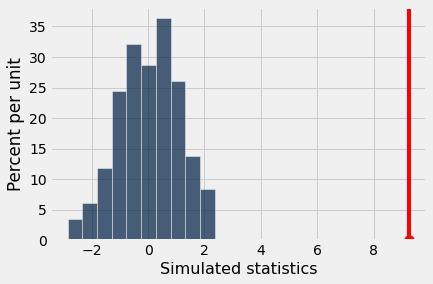

In [27]:
# Plot our array!

Table().with_column('Simulated statistics', diff_array).hist()
plots.scatter(birth_diff, 0, color='red', s=100)
plots.axvline(x=birth_diff, color = 'red');

## Things to notice:

See how our emperical histogram centers around 0? This is because if we assume our null hypothesis is true and that smoking has no affect on a babby's birth weight, then the difference of any 2 moms based purely on their smoking status should be that different. 

Our red line indicates our observed difference we calculated in the beginning.

In [28]:
# Calculate the p-value

np.count_nonzero(diff_array >= birth_diff) / len(diff_array) 

0.0

Our p-value represents assuming our null hypothesis is true, it is the probability that we will get a value as extreme or higher than our observed value. As we can visually see, no simulated value is even near our observed difference so we can say that based on this experiment, smoking has an effect on birth weight (but remember, we cannot say smoking causes birth weight defects)!

# BOOSTRAPPING

There are many differences between A/B Testing and Bootstrapping. While A/B testing checks if X is associated with Y, Bootstrapping is here to better estimate a value.

For example, let's say we have a question: What is the average weight of an brown bear?

The population here is all the brown bear in the world.

Of course, finding and measuring all the brown bears in the world is practically impossible, so we take a sample of brown bears from our population. Let's say we take a sample and find the average weight of our sample of brown bear is 1000lb. How can we be more accurate?

More samples would mean a better estimate, but that is costly and inefficient. What we can do is bootstrap, which is to generate a completely new sample based on our original sample!

Let's take a look with our baby dataset again:

In [29]:
births.show(5)

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False


Let's say we want to estimate the average Gestational Days for moms. We can simply calculate the average here.

In [33]:
# mean number of days
np.mean(births.column('Gestational Days'))

279.1013628620102

## Sampling WITH replacement

Our bootstrap sample has the following qualities:
1. Same Sample Size
2. Sampled WITH replacement

If we don't sample with replacement, we'll just end up with the same original sample and that would be disheartening :(

So let's bootstrap 500 times and find the average Gestational days per resample.

In [35]:
# create empty array to append the average
days_array = make_array()

for i in np.arange(500):
    # generate bootstrap sample. The table.sample function automatically samples with replacement and has the same sample size
    resample = births.sample()
    new_avg = np.mean(resample.column('Gestational Days'))
    days_array = np.append(days_array, new_avg)

## Confidence Interval

After bootstrapping, what we do is construct a confidence interval. For example, a 95% confidence interval contains the middle 95% of our resampled average gestational days. 

In [38]:
# Our Confidence Interval Bounds.
ci_left = percentile(2.5, days_array)
ci_right = percentile(97.5, days_array)

print("Middle 95% of bootstrappped gestational days: [{:f}, {:f}]".format(ci_left, ci_right))

Middle 95% of bootstrappped gestational days: [278.262351, 280.049404]


Here are our conclusions:

1. The average gestational days for all moms is one SINGULAR number.
2. We do not know this number, but we can estimate it.
3. From our confidence interval, we can say that we are 95% that the average gestational days for all moms is between (left CI) and (right CI)

# Using Bootstrapping to Estimate Difference

Another use of bootstrapping is to estimate the difference between 2 variables. For example, let's say we want to know if there is a difference between the average weight of babies between smoking mothers and non-smoking mothers. We can use bootstrapping for this as well!

We'll be using our birth dataset again.

In [41]:
birth.show(5)

Maternal Smoker,Birth Weight
False,120
False,113
True,128
True,108
False,136


Recall our function to find the difference of baby weight between smoking and non-smoking mothers. It will be useful.

In [42]:
# Create a function to calcualte difference between average baby birth weight for both labels

def compute(tbl):
    # grouping
    means = tbl.group('Maternal Smoker', np.mean)
    # finding the diff for each group
    diff = means.column('Birth Weight mean').item(0) - means.column('Birth Weight mean').item(1)
    return diff

# check to see if it's the same as our diff above!
compute(birth)

9.266142572024918

Here is our hypothesis again.

Null - Smoking does not have an effect on birth weights. Any variation is due to chance.

Alt - Smoking does have an effect on birth weights.

If the null hypothesis is correct, and smoking does not have an effect on birth weights, then if we find the difference between baby weights of smoking mothers and non-smoking mothers, this difference should be near 0. 

Via bootstrapping, we can generate new samples and keep finding the difference of baby weights between smoking mothers and non-smoking mothers.

In [43]:
# make an empty array to store bootstrap difference
bootstrap_array = make_array()

# make a function to bootstrap sample and compute our new difference of baby weight from this sample
def bootstrap_diff():
    boostrap_sample = birth.sample()
    diff = compute(boostrap_sample)
    return diff

# Bootstrap 500 times and store the differences in our array
for i in np.arange(500):
    bootstrap_calculation = bootstrap_diff()
    bootstrap_array = np.append(bootstrap_array, bootstrap_calculation)

## Confidence Intervals!

In [44]:
# Our 95% Confidence Interval Bounds
ci_left = percentile(2.5, bootstrap_array)
ci_right = percentile(97.5, bootstrap_array)

print("Middle 95% of bootstrappped smoking vs non-smoking baby weight: [{:f}, {:f}]".format(ci_left, ci_right))

Middle 95% of bootstrappped smoking vs non-smoking baby weight: [7.363034, 11.354839]


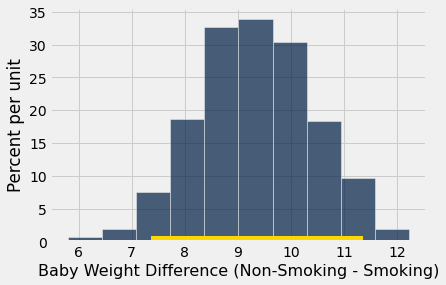

In [49]:
Table().with_column("Baby Weight Difference (Non-Smoking - Smoking)", bootstrap_array).hist()
plots.plot([ci_left, ci_right], [.005,.005], color="gold");

## Conclusions

Here the histogram represents an empircal distribution for the differences of baby weight between non-smoking and smoking mothers. The yellow bar is our confidence interval. Let's recall what we know.

1. The average baby weight of smoking mothers is a singular number (constant). We don't know what that number is.
2. The average baby weight of non-smokig mothers is a singular number (constant). We don't know what that number is.
3. The difference of baby weight between non-smoking and smoking mothers is also a constant. We also don't know what it is.
4. We sample and resample to get an estimate of the difference. Our confidence interval shows it the difference is between 7 and 11.

Under the null hypothesis, if smoking DOES not have an effect on baby weight, the difference should be around 0. However, we see that 0 is not in our C.I. While we don't know the true difference of baby weight between non-smoking and smoking mothers, we have a good estimate of what that number is, and 0 is not within that estimate. Thus, we can safely reject the null hypothesis and say that smoking is associated with baby weight.